### Classifying Depression From Activity

In our data set we have several actigraphs that monitor the activity of volunteers for study. There are 23 individuals in the condition category, and 32 individuals in the control group. We will attempt several methods to classify an individual into these two groups based on their actigraph.

First we need to import all of our data.

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier

# Read in the data
conditionData = []
controlData = []
scores = pd.read_csv("data/scores.csv")
# Separate data into a condition group and a control group
for fileName in os.listdir("data/condition"):
	conditionData.append(pd.read_csv(f"data/condition/{fileName}"))
for fileName in os.listdir(f"data/control"):
	controlData.append(pd.read_csv(f"data/control/{fileName}"))


Now we need to combine our actigraphs into one data structure with the labels indicating if it is a condition or control. We will do this by normalizing all the data to start at the first midnight (00:00:00) each person wore the sensor, and then combining all the data into one data frame object. We will also make copies of the data frame object to contain the moving average and the moving median of the data.

In [2]:

def findStartingPoint(startingPoint):
	# Find the first instance of the specified starttime to begin graphing our data
	beginIndex = 0
	c = 0
	for timestamp in data.timestamp:
		if timestamp.endswith(startingPoint):
			beginIndex = c
			break
		c += 1
	return beginIndex

timeStamp = "00:00:00"
# Raw data starting from time: 'timeStamp'
df = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:]], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	df = pd.concat([df, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:]], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	df = pd.concat([df, dfTemp])

# Raw data starting from time: 'timeStamp' divided into days
df_daySplit = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:]
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "condition"}
		dfTemp = pd.DataFrame(temp)
		df_daySplit = pd.concat([df_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:]
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "control"}
		dfTemp = pd.DataFrame(temp)
		df_daySplit = pd.concat([df_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Create Dataframe for Moving average for every 30 minutes
meandf = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(31).mean().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	meandf = pd.concat([meandf, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(31).mean().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	meandf = pd.concat([meandf, dfTemp])

meandf_daySplit = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:].rolling(31).mean().dropna()
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "condition"}
		dfTemp = pd.DataFrame(temp)
		meandf_daySplit = pd.concat([meandf_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:].rolling(31).mean().dropna()
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "control"}
		dfTemp = pd.DataFrame(temp)
		meandf_daySplit = pd.concat([meandf_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Create Datafrom for Moving median for every 30 minutes
mediandf = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(31).median().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "condition"}
	dfTemp = pd.DataFrame(temp)
	mediandf = pd.concat([mediandf, dfTemp])

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	temp = {'Activity': [data.activity[startingPoint:].rolling(31).median().dropna()], 'TimeStamp': [data.timestamp[startingPoint:]], 'Target': "control"}
	dfTemp = pd.DataFrame(temp)
	mediandf = pd.concat([mediandf, dfTemp])

mediandf_daySplit = pd.DataFrame(columns=["Activity", "TimeStamp", "Target"])
for data in conditionData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:].rolling(31).median().dropna()
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "condition"}
		dfTemp = pd.DataFrame(temp)
		mediandf_daySplit = pd.concat([mediandf_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]

for data in controlData:
	startingPoint = findStartingPoint(timeStamp)
	trimData = data.activity[startingPoint:].rolling(31).median().dropna()
	trimStartTime = data.timestamp[startingPoint:]
	# Seperate activity into days (1440 minutes in 1 day)
	while len(trimData) >= 1440:
		dayData = trimData.iloc[0:1440]
		dayStartTime = trimStartTime.iloc[0:1440]
		temp = {'Activity': [dayData], 'TimeStamp': [dayStartTime], 'Target': "control"}
		dfTemp = pd.DataFrame(temp)
		mediandf_daySplit = pd.concat([mediandf_daySplit, dfTemp])
		trimData = trimData.iloc[1440:]
		trimStartTime = trimStartTime.iloc[1440:]

First we will use a Random Forest Classifier to attempt classifying individuals with/without the condition. Because our samples are different lengths, we will need to fit our classifier only with datasets of equivalent size. We can trim data from the datasets from either the beginning of the Time Series or the end to even them out. The amount trimmed will be determined by the size of the testing data. Any data that is shorter than the test data will be left out of the training dataset.

In [3]:
'''
Trims the data to the size of the testing set. Each person wore the sensor for different time periods, so we
will even it out by trimming off the end (or begining) of the other test data to match the size of our test sample.

This will give us a new x_train, x_test, y_train, and y_test of Time Series that all have the same length. Time series 
that were too short were removed from the new test data.
'''
def formatTestData(x_train, x_test, y_train, y_test, trimFront=False):
	newXTest = []
	newYTest = []
	maxLength = len(np.array(x_test[0]))
	newXTest.append(np.array(x_test[0]))
	newXTest = np.array(newXTest)
	newYTest.append(y_test[0])

	newXTrain = []
	newYTrain = []
	for i in range(len(x_train)):
		itemCopy = np.array(x_train[i][0])
		if len(itemCopy) > maxLength:
			if trimFront:
				itemCopy = itemCopy[-maxLength:]
			else:
				itemCopy = itemCopy[:maxLength]
				
		if len(itemCopy) == maxLength:
			newXTrain.append(itemCopy)
			newYTrain.append(y_train[i])
	newYTrain = np.array(newYTrain)
	newXTrain = np.array(newXTrain)

	return newXTrain, newXTest, newYTrain, newYTest, maxLength

'''
x_train : Training data for our classifier
x_test  : Testing data for our classifier
y_train : Training labels for our classifier
y_test  : Testing labels for our classifier
numEst  : Number of estimators that our classifier will use
trimFront   : Boolean to trim data from the front. False for end.
'''
def RandomForestAccuracy(x_train, x_test, y_train, y_test, numEst=10, trimFront=True, numIters=100):
	clf=RandomForestClassifier(n_estimators=numEst)

	newXTrain, newXTest, newYTrain, newYTest, maxLength = formatTestData(x_train, x_test, y_train, y_test, trimFront)

	accuracies = []
	# Sometimes there is no data we can use and our training set is empty, so we skip these trials.
	if len(newXTrain) > 0:
		for _ in range(numIters):
			clf.fit(newXTrain, newYTrain.ravel())
			accuracy = clf.score(newXTest, newYTest)
			accuracies.append(accuracy)

	return np.average(accuracies), maxLength

Find model accuracies using the moving average data. Because the sample size is so small (55 people) we will have each person be used as the test data and then take the average accuracy of all of those to determine the accuracy of the Random Forest Classifier. 

Additionally this will show us which dataset gives us the most accurate predictions. We predict this will be the shortest dataset because this is the one that will allow the most data to be trained, giving the classifier the best chance to correctly classifiy the data. 

In [41]:
y = meandf.iloc[:,-1:]
x = meandf.iloc[: ,-3:]

y = np.array(y)
x = np.array(x)

meanFrontTrimAccuracy = []
meanFrontTrimLength = []
meanEndTrimAccuracy = []
meanEndTrimLength = []
# Because our sample size is small, we need to do 'leave-one-out accuracy'. We will be making sure each sample is used as a testing sample at least once, and average each of those
# accuracies together.
for i in range(len(x)):
	x_test = x[i]
	y_test = y[i]
	x_train = np.delete(x, i, 0)
	y_train = np.delete(y, i, 0)

	
	# Trim from the front
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), trimFront=True)
	if(not math.isnan(accuracy)):
		meanFrontTrimAccuracy.append(accuracy)
		meanFrontTrimLength.append(maxLength)
	
	
	# Trim from the end
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), trimFront=False)
	if(not math.isnan(accuracy)):
		meanEndTrimAccuracy.append(accuracy)
		meanEndTrimLength.append(maxLength)

c:\Users\spenc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\spenc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot our data so that we can visualize our findings. Each accuracy point is the average of 100 iterations of fitting and testing that specific training/testing set.

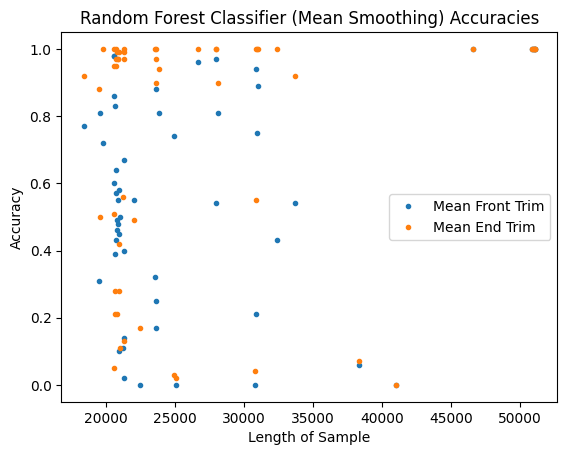

Average of the 30 smallest samples trimmed from the front: 0.5196666666666668
Average of the 30 smallest samples trimmed from the end: 0.6823333333333333


In [42]:
meanFrontList = list(zip(meanFrontTrimLength, meanFrontTrimAccuracy))
sortedMeanFrontList = sorted(meanFrontList, key=lambda x: x[0])
sortedMeanFrontX, sortedMeanFrontY = zip(*sortedMeanFrontList)

meanEndList = list(zip(meanEndTrimLength, meanEndTrimAccuracy))
sortedMeanEndList = sorted(meanEndList, key=lambda x: x[0])
sortedMeanEndX, sortedMeanEndY = zip(*sortedMeanEndList)

plt.plot(sortedMeanFrontX, sortedMeanFrontY, label="Mean Front Trim", linestyle='None', marker='.')
plt.plot(sortedMeanEndX, sortedMeanEndY, label="Mean End Trim", linestyle='None', marker='.')
plt.title("Random Forest Classifier (Mean Smoothing) Accuracies")
plt.xlabel("Length of Sample")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print(f"Average of the 30 smallest samples trimmed from the front: {np.average(sortedMeanFrontY[0:30])}")
print(f"Average of the 30 smallest samples trimmed from the end: {np.average(sortedMeanEndY[0:30])}")

Now we will do the same Random Forest Classification, but this time with a moving median dataset.

In [43]:
y = mediandf.iloc[:,-1:]
x = mediandf.iloc[: ,-3:]

y = np.array(y)
x = np.array(x)

medianFrontTrimAccuracy = []
medianFrontTrimLength = []
medianEndTrimAccuracy = []
medianEndTrimLength = []
# Because our sample size is small, we need to do 'leave-one-out accuracy'. We will be making sure each sample is used as a testing sample at least once, and average each of those
# accuracies together.
for i in range(len(x)):
	x_test = x[i]
	y_test = y[i]
	x_train = np.delete(x, i, 0)
	y_train = np.delete(y, i, 0)

	# Trim from the front
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), trimFront=True)
	if(not math.isnan(accuracy)):
		medianFrontTrimAccuracy.append(accuracy)
		medianFrontTrimLength.append(maxLength)
	
	# Trim from the end
	accuracy, maxLength = RandomForestAccuracy(x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy(), trimFront=False)
	if(not math.isnan(accuracy)):
		medianEndTrimAccuracy.append(accuracy)
		medianEndTrimLength.append(maxLength)

c:\Users\spenc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\spenc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot our data so that we can visualize our findings. Each accuracy point is the average of 100 iterations of fitting and testing that specific training/testing set.

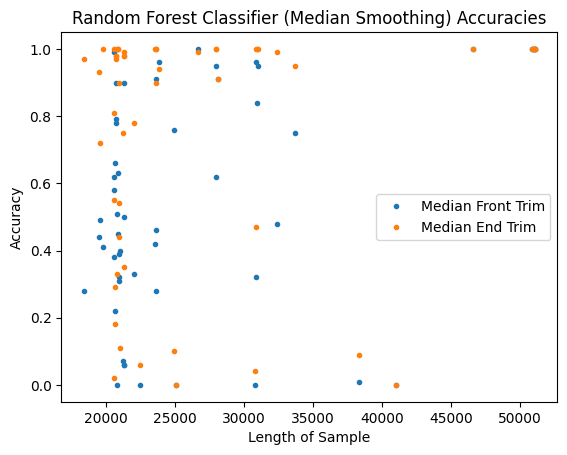

(18429, 19510, 19598, 19832, 20625, 20627, 20631, 20631, 20653, 20683, 20725, 20758, 20764, 20805, 20806, 20888, 20894, 20947, 20949, 20959, 21078, 21277, 21305, 21327, 21329, 21333, 22090, 22494, 23563, 23623, 23666, 23684, 23842, 24980, 25067, 26679, 27975, 27988, 28108, 30795, 30885, 30903, 30961, 31006, 32435, 33707, 38356, 40977, 46563, 50819, 50920, 51019, 51041, 51049)
Average of the 30 smallest samples trimmed from the front: 0.46
Average of the 30 smallest samples trimmed from the end: 0.7203333333333332


In [44]:
medianFrontList = list(zip(medianFrontTrimLength, medianFrontTrimAccuracy))
sortedMedianFrontList = sorted(medianFrontList, key=lambda x: x[0])
sortedMedianFrontX, sortedMedianFrontY = zip(*sortedMedianFrontList)

medianEndList = list(zip(medianEndTrimLength, medianEndTrimAccuracy))
sortedMedianEndList = sorted(medianEndList, key=lambda x: x[0])
sortedMedianEndX, sortedMedianEndY = zip(*sortedMedianEndList)

plt.plot(sortedMedianFrontX, sortedMedianFrontY, label="Median Front Trim", linestyle='None', marker='.')
plt.plot(sortedMedianEndX, sortedMedianEndY, label="Median End Trim", linestyle='None', marker='.')
plt.title("Random Forest Classifier (Median Smoothing) Accuracies")
plt.xlabel("Length of Sample")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print(sortedMedianEndX)
print(f"Average of the 30 smallest samples trimmed from the front: {np.average(sortedMedianFrontY[0:30])}")
print(f"Average of the 30 smallest samples trimmed from the end: {np.average(sortedMedianEndY[0:30])}")

By comparing the two accuracy graphs, we can see that our lengths are condensed around the 15000-30000 range. Our first datapoint references our data with the smallest length. Because it is the smallest in length, it means that all other samples were used in the training (as they all could be trimmed to the correct size) and therefore this represents our best fitting.

Now, you might be wondering "Why train on all the lengths if the shortest was going to be the best anyway?" Well, we didn't know that the shortest would be best, so we tried all lengths just in case the shortest length was an outlier and would not be fit for testing. But we are pleased to say that using the shortest length appears to be the best strategy. We will display a table of the shortest length combinations below:

In [45]:
print(tabulate([['Mean Front', sortedMeanFrontY[0]], 
['Mean End', sortedMeanEndY[0]], 
['Median Front', sortedMedianFrontY[0]], 
['Median End', sortedMedianEndY[0]]], headers=['Mine Type', 'Accuracy']))

Mine Type       Accuracy
------------  ----------
Mean Front          0.77
Mean End            0.92
Median Front        0.28
Median End          0.97


Why is end trimming better than front trimming? Initially we trim the data so that all samples start at midnight. By trimming off the end of the data, we are eliminating parts of the time series that do not line up with our testing time series.
It's interesting to see that the mean smoothing is generally better, but using a median end trim results in the best accuracy for our model. This might indicate that there are outliers in our data, and our moving median is the best at smoothing out those outliers.

I'd like to try the same thing but with a different classifier. Above we used a Random Forest Classifier, which works with time series but isn't necessarily built for them as they classify on random features. Using a Time Series Forest Classifier may be better as we are using time series data.

In [81]:
y = mediandf.iloc[:,-1:]
x = mediandf.iloc[: ,-3:]

y = np.array(y)
x = np.array(x)

# Find the time series with the shortest length
minIndex = 1
for i in range(len(x) - 1):
	if len(x[i][0]) < len(x[minIndex][0]):
		minIndex = i

x_test = x[minIndex]
y_test = y[minIndex]
x_train = np.delete(x, minIndex, 0)
y_train = np.delete(y, minIndex, 0)

def TSForestAccuracy(x_train, x_test, y_train, y_test, numEst, minInterval, numIters):
	tsf=TimeSeriesForestClassifier(min_interval=minInterval, n_estimators=numEst, n_jobs=-1)

	newXTrain, newXTest, newYTrain, newYTest, maxLength = formatTestData(x_train, x_test, y_train, y_test, trimFront=False)

	accuracies = []
	# Sometimes there is no data we can use and our training set is empty, so we skip these trials.
	if len(newXTrain) > 0:
		for _ in range(numIters):
			print(newXTrain)
			tsf.fit(newXTrain, newYTrain.ravel())
			accuracy = tsf.score(newXTest, newYTest)
			accuracies.append(accuracy)

	return np.average(accuracies), maxLength

TSFAccuracy, length = TSForestAccuracy(x_train, x_test, y_train, y_test, 10, 600, 10)
print(TSFAccuracy)

[[  0.   0.   0. ... 154. 184. 204.]
 [  0.   0.   0. ... 733. 756. 756.]
 [ 15.   0.   0. ...   0.   0.   0.]
 ...
 [890. 890. 890. ... 212. 212. 328.]
 [  0.   0.   0. ... 515. 549. 549.]
 [  7.   7.   7. ...  35.  36.  36.]]
[[  0.   0.   0. ... 154. 184. 204.]
 [  0.   0.   0. ... 733. 756. 756.]
 [ 15.   0.   0. ...   0.   0.   0.]
 ...
 [890. 890. 890. ... 212. 212. 328.]
 [  0.   0.   0. ... 515. 549. 549.]
 [  7.   7.   7. ...  35.  36.  36.]]
[[  0.   0.   0. ... 154. 184. 204.]
 [  0.   0.   0. ... 733. 756. 756.]
 [ 15.   0.   0. ...   0.   0.   0.]
 ...
 [890. 890. 890. ... 212. 212. 328.]
 [  0.   0.   0. ... 515. 549. 549.]
 [  7.   7.   7. ...  35.  36.  36.]]
[[  0.   0.   0. ... 154. 184. 204.]
 [  0.   0.   0. ... 733. 756. 756.]
 [ 15.   0.   0. ...   0.   0.   0.]
 ...
 [890. 890. 890. ... 212. 212. 328.]
 [  0.   0.   0. ... 515. 549. 549.]
 [  7.   7.   7. ...  35.  36.  36.]]
[[  0.   0.   0. ... 154. 184. 204.]
 [  0.   0.   0. ... 733. 756. 756.]
 [ 15.   0.   

We had an idea to separate each person's data into the several days that they participated in the experiment. This would give us a much greater sample size allowing us to train and test on more data. 

In [14]:
y = np.array(meandf_daySplit.iloc[:,-1:])
x = np.array(meandf_daySplit.iloc[: ,0:1])

# Clean up data by removing bad days where sensor was likely not working correctly
i=0
while i < len(x):
	if sum(x[i][0])<1000:
		x = np.delete(x, i, 0)
		y = np.delete(y, i, 0)
	else:
		i += 1


a = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
sss.get_n_splits(x, y)
for train_index, test_index in sss.split(x, y):
	x_train, x_test = x[train_index], x[test_index]
	y_train, y_test = y[train_index], y[test_index]

# Format data to correct type for tsf (np.array of np.arrays)
newXTrain = []
newYTrain = []
for i in range(len(x_train)):
	itemCopy = np.array(x_train[i][0])
	newXTrain.append(itemCopy)
	newYTrain.append(y_train[i])
newYTrain = np.array(newYTrain)
newXTrain = np.array(newXTrain)

newXTest = []
newYTest = []
for i in range(len(x_test)):
	itemCopy = np.array(x_test[i][0])
	newXTest.append(itemCopy)
	newYTest.append(y_test[i])
newYTest = np.array(newYTest)
newXTest = np.array(newXTest)

# Get average accuracy over 100 TS Forest classifiers
for _ in range(100):
	tsf=TimeSeriesForestClassifier(min_interval=60, n_estimators=42, n_jobs=-1)
	tsf.fit(newXTrain, newYTrain.ravel())
	accuracy = tsf.score(newXTest, newYTest)
	a.append(accuracy)
print(np.average(a))


0.7937226277372262


In [9]:
y = np.array(meandf_daySplit.iloc[:,-1:])
x = np.array(meandf_daySplit.iloc[: ,0:1])

# Clean up data by removing bad days where sensor was likely not working correctly
c=0
while c < len(x):
	if sum(x[c][0])<1000:
		x = np.delete(x, c, 0)
		y = np.delete(y, c, 0)
	else:
		c += 1

#Hyperparameter tuning:
hyper = []
for loopIndex in range(1,100):
	sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
	sss.get_n_splits(x, y)
	for train_index, test_index in sss.split(x, y):
		x_train, x_test = x[train_index], x[test_index]
		y_train, y_test = y[train_index], y[test_index]

	# Format data to correct type for tsf (np.array of np.arrays)
	newXTrain = []
	newYTrain = []
	for i in range(len(x_train)):
		itemCopy = np.array(x_train[i][0])
		newXTrain.append(itemCopy)
		newYTrain.append(y_train[i])
	newYTrain = np.array(newYTrain)
	newXTrain = np.array(newXTrain)

	newXTest = []
	newYTest = []
	for i in range(len(x_test)):
		itemCopy = np.array(x_test[i][0])
		newXTest.append(itemCopy)
		newYTest.append(y_test[i])
	newYTest = np.array(newYTest)
	newXTest = np.array(newXTest)
	runAccuracies = []

	for _ in range (10):
		tsf=TimeSeriesForestClassifier(min_interval=60, n_estimators=loopIndex, n_jobs=-1)
		tsf.fit(newXTrain, newYTrain.ravel())
		accuracy = tsf.score(newXTest, newYTest)
		runAccuracies.append(accuracy)
	print(f"Number of Estimators {loopIndex}\nAverage Accuracy {np.average(runAccuracies)}")
	hyper.append(np.average(runAccuracies))

Number of Estimators 1
Average Accuracy 0.6967153284671533
Number of Estimators 2
Average Accuracy 0.667883211678832
Number of Estimators 3
Average Accuracy 0.7167883211678833
Number of Estimators 4
Average Accuracy 0.7441605839416058
Number of Estimators 5
Average Accuracy 0.7664233576642336
Number of Estimators 6
Average Accuracy 0.7591240875912408
Number of Estimators 7
Average Accuracy 0.7306569343065694
Number of Estimators 8
Average Accuracy 0.7671532846715328
Number of Estimators 9
Average Accuracy 0.7711678832116788
Number of Estimators 10
Average Accuracy 0.7854014598540145
Number of Estimators 11
Average Accuracy 0.7963503649635038
Number of Estimators 12
Average Accuracy 0.7850364963503649
Number of Estimators 13
Average Accuracy 0.7667883211678832
Number of Estimators 14
Average Accuracy 0.7613138686131388
Number of Estimators 15
Average Accuracy 0.7846715328467153
Number of Estimators 16
Average Accuracy 0.7850364963503649
Number of Estimators 17
Average Accuracy 0.7864963

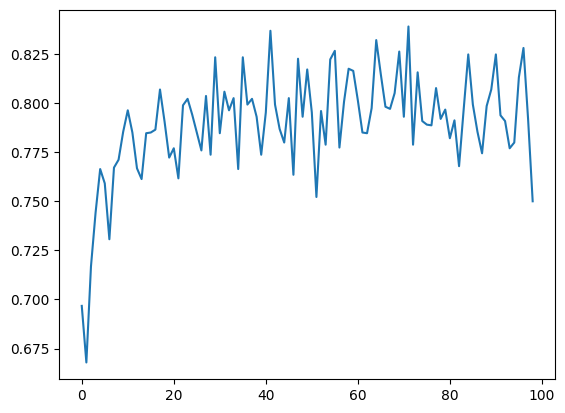

In [10]:
plt.plot(hyper)
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

y = np.array(df_daySplit.iloc[:,-1:])
x = np.array(df_daySplit.iloc[: ,-3:])

# Clean up data by removing bad days where sensor was likely not working correctly
i=0
while i < len(x):
	if sum(x[i][0])<1000:
		x = np.delete(x, i, 0)
		y = np.delete(y, i, 0)
	else:
		i += 1

a = []
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
sss.get_n_splits(x, y)
for train_index, test_index in sss.split(x, y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

accuracy, _ = TSForestAccuracy(x_train, x_test, y_train, y_test, numEst=100, minInterval=60, numIters=1)
a.append(accuracy)
print("Average Accuracy:", np.average(a))

### Showing a person's daily activity:

Stepping aside from Classifying, We were cuirious of what a person's activity actually looked like in the dataset. 

The graphs below depict the actigraph of two individuals (one classified with depression and one without). We can pretty easily tell from the graphs below the times that each person was asleep. These times are characterized by log periods of really low activity levels. Additionally, for the undepressed person, we can almost see a pattern in the data of when they went to work, had their lunch break and then went home. 

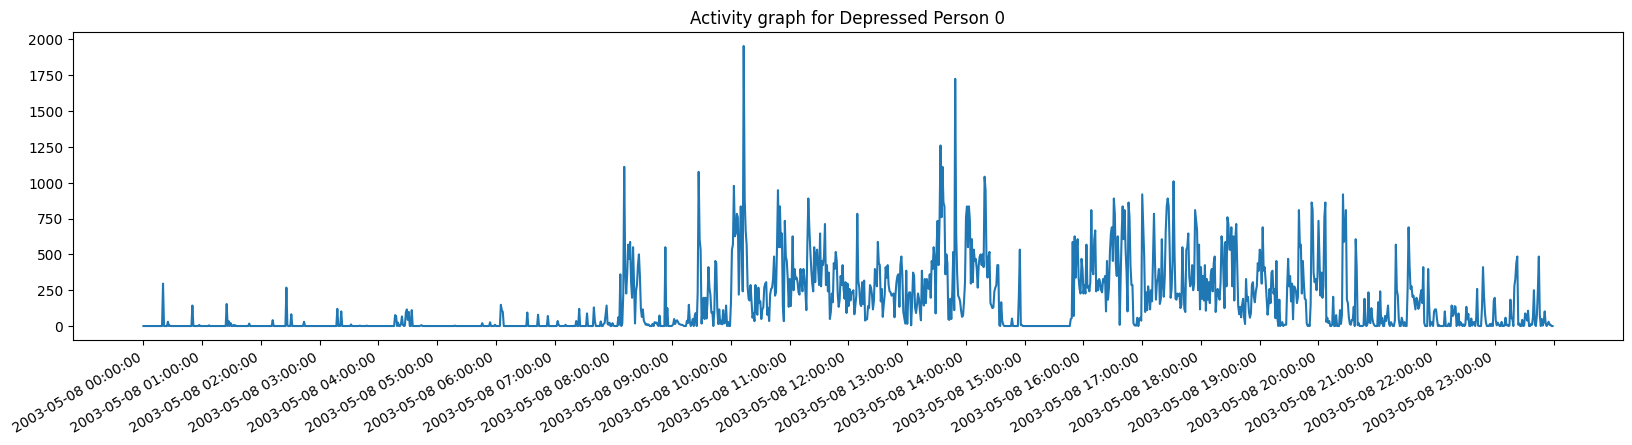

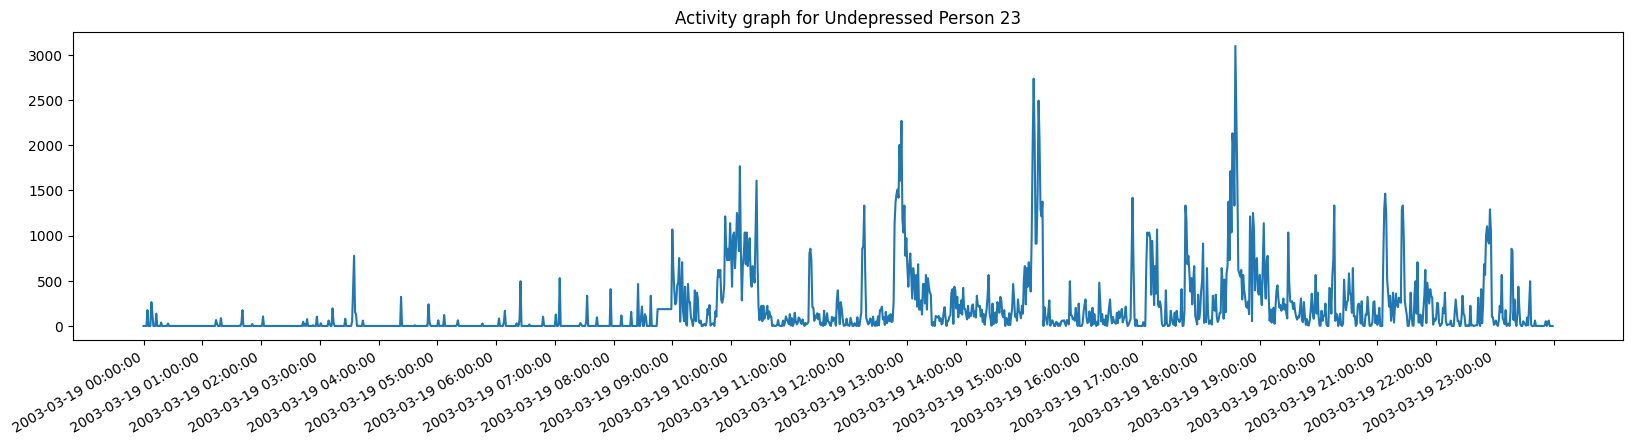

In [47]:

from datetime import datetime

def graph_person_activity(person, hours_to_display=24, start_time_str=""):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(4)

    # Find the first instance of the specified starttime to begin graphing our data
    beginIndex = 0
    if start_time_str != "":
        c = 0
        for timestamp in df.TimeStamp.tolist()[person]:
            if timestamp.endswith(start_time_str):
                beginIndex = c
                break
            c += 1
        if c >= len(df.TimeStamp.tolist()[person]):
            print("Error: Could not find specified Start Time: " + start_time_str)
            print("Defaulting to beginning of test data")
    
    # Display the activity of the person in our Datase for the number of hours selected beginning at the first applicable start time.
    plt.title(f"Activity graph for Depressed Person {person}" if df.Target.tolist()[person] == 'condition' else f"Activity graph for Undepressed Person {person}")
    plt.plot(df.TimeStamp.tolist()[person][beginIndex : beginIndex+(60*hours_to_display)], df.Activity.tolist()[person][beginIndex: beginIndex + (60*hours_to_display)])
    plt.xticks(np.arange(0, (60*hours_to_display)+ 1, 60), rotation=30, ha='right') # set xticks to every hour instead of every minute
    plt.show()


# Graph activity for first Depressed individual
graph_person_activity(0, 24, "00:00:00")
# Graph Activity for first Control individual
graph_person_activity(23, 24, "00:00:00")


### Exercise and Classifying Depression

Scientists have said that getting 30 minutes of Exercise each day is beneficial to mental health. As an experiment we can try to classify depression based on a person's exercise.

We can get the sum of the highest consecutive 30 minutes every day to determine an 'Exercise Score' for each person each day they participated in the experiment. Then we can get the average, standard deviation, min and max of each person's activity scores and try to classify them based off of that. 

In [48]:
# take a persons total activity log and split into "days" or 24 hours
# find max sum of 30 consecutive minutes and put that as a time series value. 
import math


exerciseScores = []
for person in df.Activity.tolist():
    personScores = []
    dayCount = len(person)//(24*60)
    for i in range(0, dayCount): # for each day the person participated
        maxActivity = -1
        startOfDay = i * (24*60)
        endOfDay = min(i * (24*60) + (24*60), len(person)-1)
        for j in range(startOfDay, endOfDay- 30): # for each minute in the specific day. (except the last 30 minutes)
            score = sum(person[j : j+30]) # Get the sum of the activity for the 30 minutes
            if score > maxActivity: # if this is the max then save it as the max
                maxActivity = score
        personScores.append(maxActivity) # append Score to person scores
    
    exerciseScores.append(personScores) # append each person's score TS to the exercise scores

# Clean up exercise scores by removing bad data. (Any data where the max activity for the entire day was less than 1000) 
# The reason we would get anything less than 1000 is if the person did not move at all through the whole day, or they 
# had a bad sensor.
for p in exerciseScores:
    trash = []
    for s in p:
        if s <= 1000:
            trash.append(s)
    for t in trash:
        p.remove(t)

minlen = min(len(i) for i in exerciseScores)
# create a TS with mean, std, min, and max to make each have the same length
exerciseStats = []
for person in exerciseScores:
	temp = [np.average(person), np.std(person), min(person), max(person)]
	exerciseStats.append(temp)
    


In [49]:
y = np.array(y)
x = np.array(exerciseStats)

a = []
for _ in range(100):
	sss = StratifiedShuffleSplit(n_splits=1, test_size=0.02)
	sss.get_n_splits(x, y)
	for train_index, test_index in sss.split(x, y):
		X_train, X_test = x[train_index], x[test_index]
		y_train, y_test = y[train_index], y[test_index]

	clf=RandomForestClassifier(n_estimators=10)
	clf.fit(X_train, y_train.ravel())
	accuracy = clf.score(X_test, y_test)
	a.append(accuracy)
print("Average Accuracy:", np.average(a))

Average Accuracy: 0.565


Here we see that we are getting an average score of around 50%. This shows that exercising daily does not have much coorelation with depression. One can choose to not exercise and still not have depression. Likewise a depressed person can exercise and still have depression. The results of this fun analysis do not indicate that exercise does not help allievate the symptoms of depression, only that a diagnosed person has the same ability to exercise as a person without depression.